(ws5_solution)=
# WS 5 Solution 🌱

:::{epigraph}
Quasi/natural experiments

-- TODO your name here
:::

:::{admonition} Collaboration Statement
- TODO brief statement on the nature of your collaboration.
- TODO your collaborator's names here
:::

# Learning Objectives

- Practice building simulations of causal systems
- Explore at a high level how different quasi/natural experiment designs work:
    - Instrumental variables
    - Regression discontinuities
    - Difference-in-differences

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import statsmodels.formula.api as smf

from ipywidgets import  interact_manual

rng = np.random.RandomState(42)

:::{admonition} Reading Note

For this worksheet, the research paper reading will be embedded alongside the coding exercises like the paragraph below. I've adapted the text from [Liu et al. 2021: Quantifying causality in data science with quasi-experiments](https://comsc341cd.github.io/papers/liu2021quantifying.pdf) to match the mathematical notation we have been using this semester. There is a section at the end of the original article on the intersection between causal inference and machine learning that isn't included in this worksheet, so if you are interested in that I encourage you to check it out. I'm also happy to answer any follow-up questions you might have!

:::

Outside of typical observational studies where we have to control for confounders, another framework of causality called *quasi-experiments* primarily developed in the field of economics leverages randomness naturally occurring in observed data to estimate causal effects. After undergoing a "credibility revolution" over the past few decades ([Leamer 1983](https://www.jstor.org/stable/1803924), [Angrist and Pischke 2010](https://www.aeaweb.org/articles?id=10.1257/jep.24.2.3)), economists have increasingly employed quasi-experimental techniques to estimate causal effects in real-world problems. These methods also rely on assumptions about the causal structure of the data, but these assumptions can be more plausible than conditional exchangeability/unconfoundedness. The following techniques we review leverage naturally occurring randomness to estimate causal effects.

# 1. Simulating causal systems [0.5 pts]

We've seen examples throughout the semester of how to simulate causal systems, such as in [Project 1](https://comsc341cd.github.io/projects/proj1.html#interactive-widget) and the [Lecture 6 live coding notebook](https://comsc341cd.github.io/activities/lec6_live_complete.html#lec6-live-complete), which can help us understand different study designs and DAGs.

![](../images/ws5_random_exp.png)


For example, here is a simulation of a randomized experiment corresponding to the DAG above, which is similar to the setup we saw in Project 1:

In [2]:
def sim_randomized_experiment(n_samples=10000, treatment_effect=1, covariate_effect=3):
    """
    Simulate a randomized experiment with a binary treatment, binary covariate, and continuous outcome.

    Args:
        n_samples (int): The number of samples to simulate
        treatment_effect (float): The effect of the treatment on the outcome
        covariate_effect (float): The effect of the covariate on the outcome

    Returns:
        A pandas DataFrame with the simulated data:
            - T: The treatment variable
            - X: The covariate variable
            - Y: The outcome variable
    """
    # generate binary covariate
    X = rng.choice([0, 1], size=n_samples)

    # generate binary treatment
    T = rng.choice([0, 1], size=n_samples)

    # generate outcome dependent on T and X plus noise
    Y = (treatment_effect * T) + (covariate_effect * X ) + rng.normal(0, 1, n_samples)

    return pd.DataFrame({'T': T, 'X': X, 'Y': Y})

Notice in the above code that $T$ "causes" $Y$ because the value of $Y$ depends on the value of $T$. We can think of $T$ as fully randomized because it doesn't depend on any other variables in the system.

## 1.1 simulating a single confounder [0.5 pt]

Let's begin by building a simulation of a 3 variable DAG with a single confounder:

![](../images/ws5_confounder.png)

This simulation will look very similar to the randomized experiment simulation code above, except that we will make $T$ dependent on $X$.

This can be done by determining the value of $T$ based on the value of $X$ and some noise $\epsilon \sim \mathcal{N}(0, 1)$, binarized at a threshold of 0.5:

$$
T = \begin{cases} 
    1 & \text{if } X + \epsilon > 0.5 \\
    0 & \text{otherwise}
\end{cases}
$$






In [3]:
def sim_confounder(n_samples=10000, treatment_effect=1, confounder_effect=3):
    """
    Simulate a confounded treatment and outcome with a single confounder.

    Args:
        n_samples (int): The number of samples to simulate
        treatment_effect (float): The effect of the treatment on the outcome
        confounder_effect (float): The effect of the confounder on the outcome

    Returns:
        A pandas DataFrame with the simulated data:
            - T: The treatment variable
            - X: The confounder variable
            - Y: The outcome variable


    """
    #### BEGIN SOLUTION
    X = rng.choice([0, 1], size=n_samples)
    
    T = (X + rng.normal(0, 1, n_samples) > 0.5).astype(int)
    
    Y = (treatment_effect * T) + (confounder_effect * X ) + rng.normal(0, 1, n_samples)
    #### END SOLUTION

    return pd.DataFrame({'T': T, 'X': X, 'Y': Y})

if __name__ == "__main__":
    confound_df = sim_confounder()

    assert confound_df.shape == (10000, 3), "The DataFrame should have 3 columns"
    assert confound_df['T'].nunique() == 2, "The treatment should be binary"
    assert confound_df['X'].nunique() == 2, "The confounder should be binary"

    # Feel free to add more tests here!


# 2. Instrumental variables [1.5 pts]

The first technique we will examine that uses quasi-experimental randomness is the instrumental variable (IV). The goal is to identify observable variables, *instruments* $Z$, that affect our system only through their influence on the treatment of interest $T$:

![](../images/ws5_iv.png)



## 2.1 Simulating an IV study [0.5 pts]

Complete the code below to simulate an IV study with a binary instrument $Z$. It should again be very similar to the confounded simulation code above, but now we will make $T$ dependent on both $Z$ and $X$ as well as some noise $\epsilon \sim \mathcal{N}(0, 1)$, binarized at a threshold of 1:

$$
T = \begin{cases} 
    1 & \text{if } Z + X + \epsilon > 1\\
    0 & \text{otherwise}
\end{cases}
$$

Additionally, the returned dataframe should omit the confounder $X$ to indicate that it is not observed.

In [4]:
def sim_iv(n_samples=10000, treatment_effect=1, confounder_effect=3):
    """
    Simulate an IV study with a binary instrument and confounded treatment and outcome.

    Args:
        n_samples (int): The number of samples to simulate, defaults to 10000
        treatment_effect (float): The effect of the treatment on the outcome, defaults to 1
        confounder_effect (float): The effect of the confounder on the outcome, defaults to 3

    Returns:
        A pandas DataFrame with the simulated data:
            - T: The treatment variable
            - Z: The instrument variable
            - Y: The outcome variable

    """
    #### BEGIN SOLUTION
    Z = rng.choice([0, 1], size=n_samples)
    X = rng.choice([0, 1], size=n_samples)
    T = (Z + X + rng.normal(0, 1, n_samples) > 1).astype(int)
    Y = (treatment_effect * T) + (confounder_effect * X ) + rng.normal(0, 1, n_samples)

    return pd.DataFrame({'T': T, 'Z': Z, 'Y': Y})
    #### END SOLUTION

if __name__ == "__main__":
    iv_df = sim_iv()

    assert iv_df.shape == (10000, 3), "The DataFrame should have 3 columns"
    assert iv_df['T'].nunique() == 2, "The treatment should be binary"
    assert iv_df['Z'].nunique() == 2, "The instrument should be binary"
    assert 'X' not in iv_df.columns, "The confounder should not be observed"
    
    # Feel free to add more tests here!


A famous example of IV analysis in economics ([Angrist and Krueger 1991](https://www.jstor.org/stable/2937954?seq=1)) considers the effect of the amount of required schooling $T$ on an individual’s future wages $Y$, using birth season $Z$ as an instrument. In many U.S. states, children are required to enter school the calendar year they are age six, so individuals born later in the year are young for their school grade. Because state laws require school attendance until a particular age, e.g. 16 years old, individuals are required to be in school for different amounts of time because of their birth season. As long as we can assume that birth season is effectively random and only affects an individual’s future wages through the amount of required schooling they receive, birth season can be used as an instrument to estimate causal effects.

To obtain causal estimates using IV analysis, the treatment (required schooling), outcome (future wages), and instrument (birth season) must be identified, with the assumption that the instrument only affects the outcome through its effect on the treatment. We then commonly perform what is known as *two-stage least squares*, regressing the treatment on the instrument in the first stage:

$$
T = \alpha_0 + \alpha_1 Z
$$

Then regressing the outcome on the *estimate* of the treatment from the first stage:

$$
Y = \beta_0 + \beta_1 \hat{T}
$$

The first stage extracts the “unconfounded component” of the treatment due to the effect of the instrument and uses that component in our second stage regression to estimate the causal effect, controlling for confounding in the process. The coefficient $\beta_1$ is the causal effect of the treatment on the outcome.



## 2.2 Estimating causal effects with an IV [0.5 pts]

We provide the code for a "naive" regression on the treatment that is incorrect due to the missing confounder.
Complete the `two_stage_least_squares` function using the statsmodels formula API we've been using:

In [5]:
def naive_regression(df):
    """
    Perform a regression on the treatment, which is incorrect due to the missing confounder.

    Args:
        df (pd.DataFrame): The dataframe containing the data
    """
    naive_formula = 'Y ~ 1 + T'
    naive_model = smf.ols(naive_formula, data=df).fit()
    return naive_model.params['T']


def two_stage_least_squares(df):
    """
    Perform two-stage least squares estimation for instrumental variables.

    Args:
        df (pd.DataFrame): The dataframe containing the data

    Returns:
        float: The causal effect of the treatment on the outcome
    """
    ### BEGIN SOLUTION
    first_stage_formula = 'T ~ 1 + Z'


    first_stage = smf.ols(first_stage_formula, data=df).fit()

    # Add the predicted treatment values to the dataframe
    df['T_hat'] = first_stage.predict(df)

    second_stage_formula = 'Y ~ 1 + T_hat'
    
    second_stage = smf.ols(second_stage_formula, data=df).fit()

    return second_stage.params['T_hat']
    ### END SOLUTION

if __name__ == "__main__":
    iv_df = sim_iv()
    estimate = two_stage_least_squares(iv_df)

    assert isinstance(estimate, float), "The estimate should be a float"
    # Feel free to add more tests here!

Next, complete the simulation method below to plot the distribution of the causal effect estimates from the naive regression and the two-stage least squares estimator.

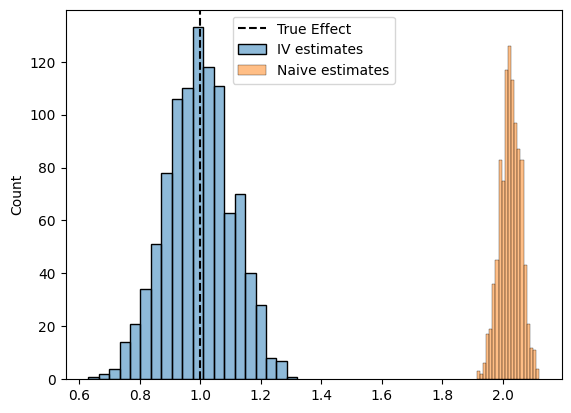

In [6]:
def plot_iv_estimates():
    """
    Plot the distribution of the causal effect estimates from the naive regression and the two-stage least squares estimator.

    Args:
        n_samples (int): The number of samples to simulate
        treatment_effect (float): The effect of the treatment on the outcome
        confounder_effect (float): The effect of the confounder on the outcome
    """

    # simulate 1000 iv datasets
    n_datasets = 1000

    iv_estimates = []
    naive_estimates = []

    for _ in range(n_datasets):

        # Simulate an IV dataset with the default parameters
        iv_df = sim_iv()

        ### BEGIN SOLUTION
        iv_df = sim_iv()
        # compute the causal effect estimate from the naive regression
        naive_estimates.append(naive_regression(iv_df))
        # compute the causal effect estimate from the two-stage least squares estimator
        iv_estimates.append(two_stage_least_squares(iv_df))

        ### END SOLUTION

    # The true effect is 1 for the default parameters
    plt.axvline(1, color='black', linestyle='--', label='True Effect')

    # Plot a histogram of IV estimates and naive estimates
    ### BEGIN SOLUTION
    sns.histplot(iv_estimates, bins=20, alpha=0.5, label='IV estimates')
    sns.histplot(naive_estimates, bins=20, alpha=0.5, label='Naive estimates')
    ### END SOLUTION
    
    plt.legend()
    plt.show()

if __name__ == "__main__":
    plot_iv_estimates()

:::{admonition} Takeaway (click this once you've completed the plot)
:class: dropdown

You should find that the IV estimate is unbiased -- though likely with higher variance -- while the regression estimate is more precise but biased.

:::

There are a number of assumptions and considerations to be made when performing IV analysis to ensure valid estimation. We need to assume **instrument unconfoundedness** -- in other words, there is no confounding variable influencing both the instrument itself and the outcome Y. The diagram below shows an example of a violation of instrument unconfoundedness:

![](../images/ws5_iv_unconfoundedness.png)


Though this can be a strong assumption, it often more justifiable than the typical unconfoundedness assumption because the instrument is chosen to be random: it is more plausible to argue that birth season is unconfounded with future wages than it is to argue that our treatment T schooling is unconfounded with future wages. We also need to ensure the instrument only affects the outcome through its effect on the treatment, known as the **exclusion restriction**. A violation of the exclusion restriction occurs if there are other paths from the instrument to the outcome other than through the treatment. For example, in the diagram below, the instrument Z affects the outcome Y through the treatment T as well as a direct effect on Y:

![](../images/ws5_iv_exclusion.png)

Furthermore, successful instruments must be **relevant** and correlate strongly with the treatment, as weakly correlated instruments lack the statistical efficiency to produce practically useful estimates. It is important to ensure that these assumptions are met, as violations of any of these assumptions could threaten the validity of the results. 

For example, though weather is a popular instrument considered for IV analysis because changes in weather in a region are plausibly random, it may not be appropriate depending on the specific causal question being asked. Consider a behavioral scientist who wishes to study the effect of exercise on mental wellbeing and plans to use temperature as an instrument on the amount of exercise individuals get. Though it tells an intuitive story where temperature “randomizes” the amount of exercise individuals get, temperature may in fact be only weakly correlated with exercise depending on the type of activity (e.g. indoor exercises are not affected as much by temperature), or more concerningly, may violate the exclusion restriction (temperature may also influence mental health outside of exercise, such as through seasonal affective disorder). In this situation, though it seems that weather is a good candidate for IV analysis, a closer consideration of all the assumptions reveal flaws in the study design.

Provided that we find an appropriate instrument such that these assumptions are plausible, IV analysis can be used broadly across many disciplines to estimate causal effects in nonexperimental data by leveraging observable sources of randomness.




## 2.3 IV study discussion [0.5 pts]

Below is a table of prior instrumental variable studies:

| Paper and Domain | Question | Treatment (T) | Instrument (Z) | Outcome (Y) |
|-------------|----------|---------------|----------------|-------------|
| [Zhao et al. 2021](https://academic.oup.com/ije/article/48/5/1478/5531250) (Medicine) | Using genome-wide association study data, what is the relationship between cholesterol and cardiovascular disease? | High-density lipoprotein (HDL) cholesterol levels | Variation in thousands of genes that affect HDL cholesterol levels | Coronary artery disease and heart attack risk |
| [Sharma et al. 2015](https://dl.acm.org/doi/10.1145/2764468.2764488) (Tech industry) | How do product recommendations affect what products customers view? | Product recommendation | Shock in popularity to product next to recommended product | Click-through rate on the recommended product |
| [Huan and Levinson 2010](https://www.sciencedirect.com/science/article/abs/pii/S002243751000112X) (Public Safety) | Does sleep deprivation result in more car accidents? | Sleep amount | Daylight savings time | Vehicle crash statistics |
| [Lepperød et al. 2018](https://www.biorxiv.org/content/10.1101/463760v4) (Neuroscience) | Are neurons A and B causally connected to each other? | Optogenetic stimulation of neuron A | Random refractory periods of other neurons | Whether neuron B fires |

For one of the studies above, briefly discuss the validity of the instrument in terms of the **instrument unconfoundedness** and **exclusion restriction** assumptions. In your opinion, does the instrument seem to be in line with the necessary assumptions?

**Your Response**: Varies

# 3. Regression discontinuities

Another method of leveraging naturally occurring randomness to estimate causality is the regression discontinuity design (RDD). In RDDs, our treatment of interest $T$ is assigned according to a sharp cutoff of a continuous running variable $R$, such as age, a standardized test score, or a blood pressure reading. Because the cutoff is sharp (e.g., if age 50 or above, patients get screened for cancer, otherwise they do not), the treatment assignment $T$ is “as good as random” (quasi-random) for individuals near the cutoff $Z$, allowing for the estimation of the causal effect of treatment $T$ on the outcome $Y$:

![](../images/ws5_rdd.png)

The classic RDD example ([Thistlewaite and Campbell 1960](https://psycnet.apa.org/fulltext/1962-00061-001.pdf)) concerns high school academic recognition $T$ and their effect on subsequent academic achievement such as receiving college scholarships$Y$. U.S. high school students take a standardized exam called the National Merit Scholarship Qualifying Test (NMSQT®), with students who meet a minimum score cutoff being nationally recognized with a Certificate of Merit $T$, increasing their chances of receiving college scholarships. Here, the continuous running variable is the NMSQT test score $R$. Students who just meet the cutoff $Z=1$ are not materially different from students who just miss the cutoff $Z=0$, essentially randomizing assignment of the Certificate of Merit **near the cutoff score**. This quasi-randomization design allows estimation of the causal relationship between the Certificate of Merit and future academic achievement for students around the threshold.



## 3.1 Simulating a regression discontinuity [0.5 pts]


Complete the code below to simulate a simple RDD study, without confounding. We'll generate a continuous running variable $R$ with a uniform distribution between 0 and 1:

```python
R = rng.uniform(0, 1, n_samples)
```

The cutoff indicator $Z$ should be binarized at a threshold of $R\gt0.5$:

$$
Z = \begin{cases} 
    1 & \text{if } R > 0.5\\
    0 & \text{otherwise}
\end{cases}
$$

The treatment $T$ should then be completely determined by the cutoff indicator $Z$:

$$
T = \begin{cases} 
    1 & \text{if } Z = 1\\
    0 & \text{otherwise}
\end{cases}
$$

This indicates that a unit above the threshold will always receive the treatment, while a unit below the threshold will never receive the treatment. 

:::{admonition} Note

You might wonder why we have the "above the cutoff" indicator $Z$ when $T$ is just equal to $Z$. This is because we want to logically separate out the treatment assignment from the cutoff indicator. Our simple simulation produces a "sharp" RDD, where the treatment is completely determined by the cutoff indicator. In practice, there are also "fuzzy" RDDs, where the probability of treatment is influenced by the cutoff indicator but not completely determined by it. We'll discuss this situation when we get to the implementation details of RDDs.

:::


In [7]:
def sim_rdd(n_samples=10000, treatment_effect=2, running_effect=1):
    """
    Simulate an RDD study with a continuous running variable, a cutoff indicator, and confounded treatment and outcome.

    Args:
        n_samples (int): The number of samples to simulate
        treatment_effect (float): The effect of the treatment on the outcome, defaults to 1
        running_effect (float): The effect of the running variable on the outcome, defaults to 1

    Returns:
        A pandas DataFrame with the simulated data:
            - T: The treatment variable
            - Z: The cutoff indicator variable
            - R: The running variable
            - Y: The outcome variable
    """

    # TODO generate the running variable with a uniform distribution between 0 and 10
    R = 0

    # TODO generate the cutoff indicator with a threshold of R > 5
    Z = 0
    
    # TODO generate treatment dependent on Z, X, and noise in the same way as the IV study
    T = 0
    
    #### BEGIN SOLUTION
    R = rng.uniform(0, 1, n_samples)
    Z = (R > 0.5).astype(int)
    T = Z
    #### END SOLUTION

    # Generate the outcome
    Y = treatment_effect * T + running_effect * R + rng.normal(0, 1, n_samples)

    return pd.DataFrame({'T': T, 'Z': Z, 'R': R, 'Y': Y})

if __name__ == "__main__":
    rdd_df = sim_rdd()

    assert rdd_df['T'].nunique() == 2, "The treatment should be binary"
    assert rdd_df['Z'].nunique() == 2, "The cutoff indicator should be binary"
    assert np.all(rdd_df[rdd_df['R'] > 0.5]['Z'] == 1), "The cutoff indicator should be 1 for all running variables greater than 0.5"

A common method to obtain causal estimates using RDD is to fit two linear regressions of the running variable $R$ (test score) on the outcome $Y$ (scholarship amount) both below and above the threshold, called *local linear regression*. The causal effect of the treatment $T$ (Certificate of Merit) at the threshold is the difference in the two fitted regressions' predicted value at the threshold. A practical consideration of implementing RDDs concerns bandwidth size: how far from the threshold can an individual be and still have effectively random treatment? Smaller bandwidths make it more plausible for treatment to be quasi-random but also reduce the sample size of the regressions fitted. On the other hand, larger bandwidths may introduce bias into our estimates, particularly if the relationship between the running variable $R$ and the outcome $Y$ is nonlinear.

## 3.2 Local linear regressions for RDD [0.5 pts]

Complete the code below to fit local linear regressions below and above the threshold of $R=0.5$:

$$
Y_{\text{below}} = \alpha_0 + \alpha_1 R, \quad \text{ for data where } R \leq 0.5
$$

$$
Y_{\text{above}} = \beta_0 + \beta_1 R, \quad \text{ for data where } R > 0.5
$$

The causal effect of the treatment $T$ the difference in the two fitted regressions' predicted value exactly at the threshold value.

In [8]:
def fit_local_linear_regressions(df, threshold=0.5):
    """
    Fit local linear regressions to the left and right of the threshold.

    Args:
        df (pd.DataFrame): The dataframe containing the data
        threshold (float): The threshold value of the running variable, defaults to 0.5

    Returns:
        tuple (below, above): the fitted regressions below and above the threshold
    """
    ### BEGIN SOLUTION
    # Select the dataframe rows for data below the threshold
    below_df = df[df['R'] <= threshold]
    # select the dataframe rows for the data above the threshold
    above_df = df[df['R'] > threshold]
    # Fit a linear regression of Y on R below the threshold
    below_regression = smf.ols('Y ~ R', data=below_df).fit()
    # Fit a linear regression of Y on R above the threshold
    above_regression = smf.ols('Y ~ R', data=above_df).fit()
    ### END SOLUTION

    # Generate a dataframe with the threshold value of R
    #threshold_df = pd.DataFrame({'R': [threshold]})
    #return (below_regression.predict(threshold_df) - above_regression.predict(threshold_df))[0]
    
    return below_regression, above_regression
    
if __name__ == "__main__":
    rdd_df = sim_rdd()
    below, above  = fit_local_linear_regressions(rdd_df)

    assert 'R' in below.params, "The running variable should be in the regression"
    assert 'R' in above.params, "The running variable should be in the regression"

    # Feel free to add more tests here!


We can then plot these two regressions against the data to visualize the discontinuity at the threshold:

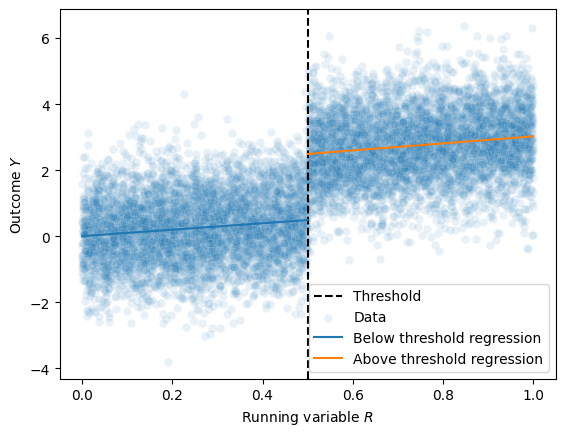

In [9]:
def plot_rdd(df, below_regression, above_regression, threshold=0.5):
    """
    Plot the RDD data and the fitted regressions.
    """
    # Generate a dataframe with R values from 0 to 0.5
    below_df = pd.DataFrame({'R': np.linspace(0, 0.5, 10)})

    # Generate a dataframe with R values from 0.5 to 1
    above_df = pd.DataFrame({'R': np.linspace(0.5, 1, 10)})
    
    # Plot the threshold as a vertical line
    plt.axvline(x=threshold, color='black', linestyle='--', label='Threshold')
    
    ### BEGIN SOLUTION
    below_df = pd.DataFrame({'R': np.linspace(0, 0.5, 100)})
    above_df = pd.DataFrame({'R': np.linspace(0.5, 1, 100)})
    below_predictions = below_regression.predict(below_df)
    above_predictions = above_regression.predict(above_df)

    sns.scatterplot(data=df, x='R', y='Y', label='Data', alpha=0.1)
    sns.lineplot(data=below_df, x='R', y=below_predictions, label='Below threshold regression')
    sns.lineplot(data=above_df, x='R', y=above_predictions, label='Above threshold regression')
    ### END SOLUTION

    plt.xlabel('Running variable $R$')
    plt.ylabel('Outcome $Y$')
    plt.legend()
    plt.show()



if __name__ == "__main__":
    rdd_df = sim_rdd(treatment_effect=2)
    below_regression, above_regression = fit_local_linear_regressions(rdd_df)
    plot_rdd(rdd_df, below_regression, above_regression)


:::{admonition} Takeaway (click this once you've completed the plot)
:class: dropdown

You should be able to visually see that the difference between the two regressions at the threshold is the causal effect of the treatment -- which in the case of this simulation should be about 2.

:::

There are several assumptions needed when performing RDD analysis to ensure valid estimation. We assume that only the running variable $R$ has a discontinuous jump that drives the causal relationship between the treatment and the outcome. This assumption can be falsified in practice by verifying the continuity of other measured covariates at the cutoff value of $R$.  Another critical assumption requires that individuals cannot perfectly manipulate the running variable, as this could make the groups above and below the threshold incomparable. In our above example, if some students can precisely control their test score such that they do *just enough* studying to achieve the Certificate of Merit cutoff, that would violate the quasi-randomization of treatment. Economists have developed tests for this form of running variable manipulation enabling falsification of the assumption. Notably, the running variable does not need to be unconfounded to make valid causal estimates. It is almost certainly the case that a student's test score $R$ is generally confounded with their subsequent academic achievement $Y$ -- however the claim of the RDD is that close to the score cutoff, the treatment assignment $T$ is as good as random. Because of its relatively weak and often falsifiable assumptions, RDD is known as one of the most credible quasi-experimental designs for estimating causality without a randomized experiment.

However, though it is tempting to try and apply RDD analysis whenever there is a threshold determining treatment assignment, there are plausible situations where these assumptions do not hold. The assumption that units just above and below the threshold are comparable needs to be carefully considered in practice, as violations often arise when individuals in the study know the cutoff and the score. For example, one may study the effect of grant awards on future academic success of young scientists, utilizing NIH payline cutoffs for fellowship and grant fundings for an RDD analysis. However, since payline cutoffs are made public, it is likely that scientists who know they just missed the cutoff are further motivated to work harder than scientists that just barely made the cutoff, potentially biasing estimates of future success because the scientists just above and below the cutoff differ in motivation. 

Provided that the assumptions can be justified, RDD analysis has the potential to be widely applicable in estimating causal effects as thresholds exist in many domains (see the table below), even in unconventional settings such as geographic boundaries.


| Paper and Domain | Question | Treatment $T$ | Running Variable $R$ & Threshold $Z$ | Outcome $Y$ |
|--------|-------------------|-----------|------------------------------|---------|
| [Bor et al. 2014](https://pubmed.ncbi.nlm.nih.gov/25061922/) (Medicine) | When should HIV patients get started on antiretroviral therapy? | Antiretroviral therapy | CD4 T-cell count and threshold for treatment administration | Mortality |
| [Chen et al. 2013](https://www.pnas.org/doi/10.1073/pnas.1300018110) (Climate Science) | How does air pollution influence life expectancy? | Air pollutants from burning coal | Distance from river and subsidized coal policy north of the river | Life expectancy |
| [Kadiyala and Strumpf 2016](https://www.degruyter.com/document/doi/10.1515/fhep-2014-0014/html) (Public Health) | How effective is early breast cancer screening in reducing mortality? | Breast cancer screening | Age and recommended screening age guidelines | Mortality |
| [Lansdell and Kording 2023](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1011005) (Neuroscience) | How do neurons learn to optimize their activity? | Neuron spiking | Input neural drive and spiking threshold | Observed reward for neuron |



## 3.2 RDD discussion [0.5 pt]

Think of a real-world setting where a decision or "treatment" is assigned based on exceeding (or falling below) a specific threshold value. Describe how you could apply an RDD to study a causal outcome in this setting by identifying:

- Running variable $R$: TODO
- Cutoff $Z$: $R$ > ? or $R$ < ?
- Treatment $T$: TODO
- Outcome $Y$: TODO

Briefly discuss why this scenario could be appropriate for RDD analysis.

**Your Response**: Varies

# 4. Difference-in-differences

A third standard econometric approach called difference-in-differences (DiD) addresses confounding in observational data by looking at a treated and a control group and comparing their outcome trends over time. We have measurements of outcome $Y$ in time periods before ($Y_{\text{pre}}$) and after ($Y_{\text{post}}$) treatment $T$ for both a treated group that receives the treatment and a control group that does not receive treatment. The simple difference $\delta_{\text{treat}} = Y_{\text{treat, post}} - Y_{\text{treat, pre}}$ of the treated group could serve as an estimate of the causal effect of $T$, but it may be confounded by unobserved factors or time effects. The idea of the DiD is to use the difference $\delta_{\text{control}} = Y_{\text{control, post}} - Y_{\text{control, pre}}$ of the control group as an estimate of confounding affecting the treated group, correcting for this effect by subtracting this second difference.

The classic example of DiD in economics concerns the effect of raising the minimum wage $T$ on employment $Y$ ([Card and Krueger 1993](https://www.nber.org/system/files/working_papers/w4509/w4509.pdf)). New Jersey raised the minimum wage in 1992, while the bordering state of Pennsylvania did not. The study compared fast food restaurant employment numbers from both states before and after the policy change. Changes in employment when looking only at New Jersey could have been confounded by other factors, such as a national recession. However, by subtracting the difference in employment observed in Pennsylvania, which did not see a minimum wage increase but is plausibly equally affected by confounders due to geographic and demographic similarities, the authors could control for potential confounding. 

To perform DiD analysis, we use longitudinal data to make estimates of $Y_{\text{pre}}$ and $Y_{\text{post}}$ (for example, pre- and post-minimum wage increase) for both the control and treated groups. The estimates can be single expectations computed over the pre and post time periods or, if the practitioner wishes to include multiple time points and control for other covariates, the estimates can be made with a time series regression. We then take a difference between the estimated differences of the outcome values between the treated and control groups $\delta_{\text{treat}} - \delta_{\text{control}}$, which yields a valid estimate of the effect treatment $T$ has on outcome $Y$ by subtracting out confounding factors that influence both the control and treated group equally. We note here that DiD analyses are a particular regression method for estimating causality from time series, with variations of DiD available for nonparametric and nonlinear settings. The **synthetic control**, related to DiD, is another technique developed in economics to estimate causal effects from time series data ([Abadie 2021](https://www.aeaweb.org/articles?id=10.1257/jel.20191450)).

Like the other quasi-experimental designs, DiD analysis requires assumptions to ensure valid causal estimates. The most important assumption is the presence of **parallel trends**: we require that the treated and control groups are not differentially affected by confounding factors over time. In our minimum wage example, the parallel trends assumption would be violated if the Pennsylvania labor market reacted differently from the one in New Jersey to the ongoing recession. If the longitudinal data contains multiple time points, the parallel trends assumption can be tested by examining the outcome $Y$ in the two groups before the treatment $X$ is applied. Another assumption required is the absence of **spillover effects**, where intervention itself results in a change in the composition of the control and treated groups. This would be violated if the new minimum wage in New Jersey resulted in different individuals to re-enter the job market or for individuals from Pennsylvania to move to New Jersey.  For DiD analyses to be valid, we need evidence to support both parallel trends and the absence of spillover effects.



## 4.1 Difference-in-differences simulation [0.5 pts]

Below is a simple simulation of a linear difference-in-differences study. It generates four total time periods, with three pre-treatment ($t=0, 1, 2$) and one post-treatment ($t=3$). We can assume that the treatment event occurred at time period $t=2.5$. 

Complete the `estimate_did` function to compute the diff-in-diff estimate between time periods 2 and 3:

$$
\delta_{\text{treat}} = Y_{\text{treat, } t=3} - Y_{\text{treat, } t=2}
$$

$$
\delta_{\text{control}} = Y_{\text{control, } t=3} - Y_{\text{control, } t=2}
$$

$$
\delta_{DiD} = \delta_{\text{treat}} - \delta_{\text{control}}
$$

:::{tip}

Depending on your implementation, you may need to extract individual floats from the pandas columns. You can do this by first converting the column to a numpy array using `df[col].values` and then selecting the first element. For example:

```python
df[df['time'] == 0]['Y_treat'].values[0]
```

would return the float of $Y_{\text{treat, } t=0}$ from the dataframe `df`.

:::

In [ ]:
def sim_did(control_slope=1.0, treated_slope=1.0, treatment_effect=2.0):
    """
    Simulate a difference-in-differences study with adjustable slopes and treatment effect.

    Args:
        control_slope (float): Slope of the control group trend
        treated_slope (float): Slope of the treated group trend (pre-treatment)
        treatment_effect (float): Effect of treatment in the post-period
    """

    periods = np.array([0, 1, 2, 3])

    # Have the treated and control groups follow their trends with different intercepts
    control_outcomes = 2 + control_slope * periods
    treated_outcomes = 4 + treated_slope * periods

    # Apply the treatment effect to the treated group at time period 3
    treated_outcomes[3] += treatment_effect

    return pd.DataFrame({
        'Y_treat': treated_outcomes,
        'Y_control': control_outcomes,
        'time': periods
    })

def estimate_did(did_df, pre_period, post_period):
    """
    Estimate the difference-in-differences (DiD) between the treated and control groups for the given pre- and post-periods.

    Assumes the following columns in did_df:
        - time
        - Y_treat
        - y_control

    Args:
        did_df (pd.DataFrame): DataFrame containing the data
        pre_period (int): The pre-treatment period
        post_period (int): The post-treatment period

    Returns:
        float: The difference-in-differences estimate
    """
    #### BEGIN SOLUTION
    delta_treat = did_df.loc[did_df['time'] == post_period, 'Y_treat'].values[0] - did_df.loc[did_df['time'] == pre_period, 'Y_treat'].values[0]
    delta_control = did_df.loc[did_df['time'] == post_period, 'Y_control'].values[0] - did_df.loc[did_df['time'] == pre_period, 'Y_control'].values[0]
    did_estimate = delta_treat - delta_control
    #### END SOLUTION

    return did_estimate


if __name__ == "__main__":
    did_df = sim_did(treatment_effect=2)

    did_effect = estimate_did(did_df, pre_period=2, post_period=3)

    assert isinstance(did_effect, float), "The estimate should be a float"

    assert did_effect == 2.0, "The DiD estimate should be 2.0"

## 4.1 Difference-in-differences parallel trends widget [0.5 pts]

Complete the widget below plotting the DiD data by filling in the TODOs and plotting a vertical line segment corresponding to the DiD estimate, where the first coordinate is $(3, \;Y_{\text{treat, } t=3})$ and the second coordinate is $(3, \;Y_{\text{treat, } t=3} - \delta_{DiD} )$.

To plot arbitrary line segments, we can use `plt.plot((x1, x2), (y1, y2))` to show a line segment between the points $(x1, y1)$ and $(x2, y2)$. For example:

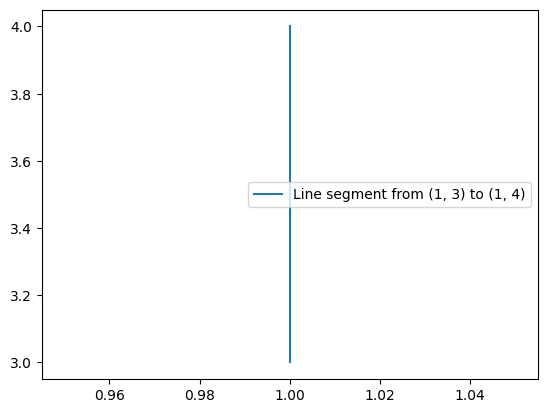

In [11]:
if __name__ == "__main__":
    plt.plot((1, 1), (3, 4), label='Line segment from (1, 3) to (1, 4)')
    plt.legend()
    plt.show()


Additionally, plot the counterfactual trend for the treated group, which represents the hypothetical scenario where the treatment effect is not applied. This is the treated group trend minus the treatment effect for the post-treatment period $t=3$ within the `show_counterfactual` conditional statement.

In [14]:
@interact_manual()
def plot_did(control_slope=1.0, treated_slope=1.0, show_counterfactual=False):
    """
    Linear DiD visualization with adjustable parameters to explore the effects of parallel trends.

    Args:
        control_slope (float): Slope of the control group trend
        treated_slope (float): Slope of the treated group trend (pre-treatment)
        treatment_effect (float): Effect of treatment in the post-period
        show_counterfactual (bool): Toggle whether to show the counterfactual trend
    """
    # Generate the data using sim_did with a fixed treatment effect=2
    treatment_effect = 2
    did_df = sim_did(control_slope, treated_slope, treatment_effect=treatment_effect)

    # TODO compute the diff-in-diff estimate using estimate_did
    did_effect = 0

    # TODO plot Y_treat and Y_control against time using sns.lineplot
    # use markers='o' to plot markers at each time period
    
    if show_counterfactual:
        Y_counterfactual = did_df['Y_treat'].values.copy()
        # TODO modify Y_counterfactual to be the counterfactual trend by su

        # TODO plot Y_counterfactual against time using markers='o' and ls='--' for dotted lines

    
    # TODO plot the specified line segment labelled "DiD estimate"

    # Plots the treatment event as a vertical line
    plt.axvline(x=2.5, color='gray', linestyle='--')
    
    # plt.title(f'DiD Estimate: {did_effect:.2f}   (True Effect: {treatment_effect:.2f})')
    # plt.legend()

    ### BEGIN SOLUTION
    sns.lineplot(data=did_df, x='time', y='Y_treat', label='Treated Group', marker='o')
    sns.lineplot(data=did_df, x='time', y='Y_control', label='Control Group', marker='o')


    did_effect = estimate_did(did_df, pre_period=2, post_period=3)

    Y_treat_3 = did_df[did_df['time'] == 3]['Y_treat'].values[0]

    plt.plot((3, 3), (Y_treat_3, Y_treat_3 - did_effect), label=f'DiD = {did_effect:.2f}')

    if show_counterfactual:
        Y_counterfactual = did_df['Y_treat'].values.copy()
        Y_counterfactual[3] -= treatment_effect
        sns.lineplot(data=did_df, x='time', y=Y_counterfactual, label='Treated Group', marker='o', ls='--')

    ### END SOLUTION

    plt.title(f'DiD Estimate: {did_effect:.2f}   (True Effect: {treatment_effect:.2f})')
    plt.legend()

interactive(children=(FloatSlider(value=1.0, description='control_slope', max=3.0, min=-1.0), FloatSlider(valu…

Explore the effects different slopes for the control and treated groups have on the DiD estimate by changing the sliders and toggling the counterfactual plot. What do you observe about the DiD estimate and counterfactual trend when the slopes are the same?

**Your Response**: Varies

The parallel trends assumption is violated if the control and treated groups have different slopes. Does the DiD estimate over or underestimate the true effect when the treated group slope is steeper than the control group slope?

**Your Response**: Varies



:::{admonition} Takeaway (click this once you've completed this section)
:class: dropdown

In the case where the parallel trends assumption holds, we should expect the DiD estimate to correspond exactly to the difference between the actual treated outcome and the counterfactual treated outcome in the post-treatment period $t=3$.

:::

# 5. Reflection [0.5 pts]

**5.1** How much time did it take you to complete this worksheet?

**Your Response**: Varies

**5.2** What is one thing you have a better understanding of after completing this worksheet and going through the class content this week? This could be about the concepts, the reading, or the code.

**Your Response**: Varies

**5.3** What questions or points of confusion do you have about the material covered covered in the past week of class?

**Your Response**: Varies

:::{tip}
Don't forget to check that all of the TODOs are filled in before you submit!
:::